In [6]:
import toml
import torch
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm
from aging.size_norm.data import Session
from aging.size_norm.lightning import predict
from aging.plotting import figure, legend, format_plots
from kornia.geometry.transform import scale

In [7]:
format_plots()

In [2]:
model_paths = sorted(Path('/home/wg41/groups/win/longtogeny/size_norm/models/ae_augmentation_scan_00').glob('**/model.pt'))

In [3]:
def load_frames():
    np.random.seed(0)
    folder = Path("/n/groups/datta/Dana/Ontogeny/raw_data/Dana_ontogeny/Males/3months_19042021")
    # load input data
    depth_files = sorted(folder.glob("**/results_00.h5"))

    frames = []
    for file in depth_files[:1]:
        with h5py.File(file, 'r') as f:
            frames.append(f['frames'][()][::2])
    frames = np.concatenate(frames, axis=0)
    test_frame_array = [frames[100], frames[500], frames[1110], frames[1810], frames[1910], frames[2010], frames[2400], frames[2600]]
    test_frame_array += frames[np.random.randint(0, len(frames), 32)].tolist()
    return np.array(test_frame_array)


In [4]:
test_frames = load_frames()

  0%|          | 0/13 [00:00<?, ?it/s]

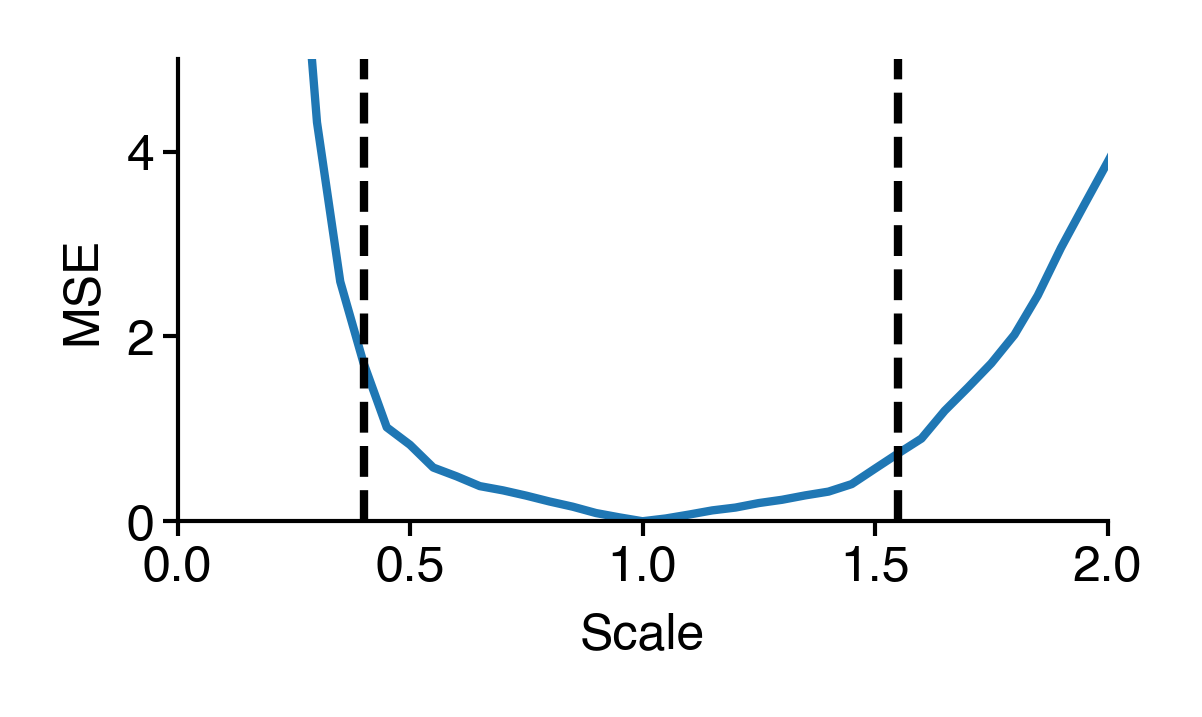

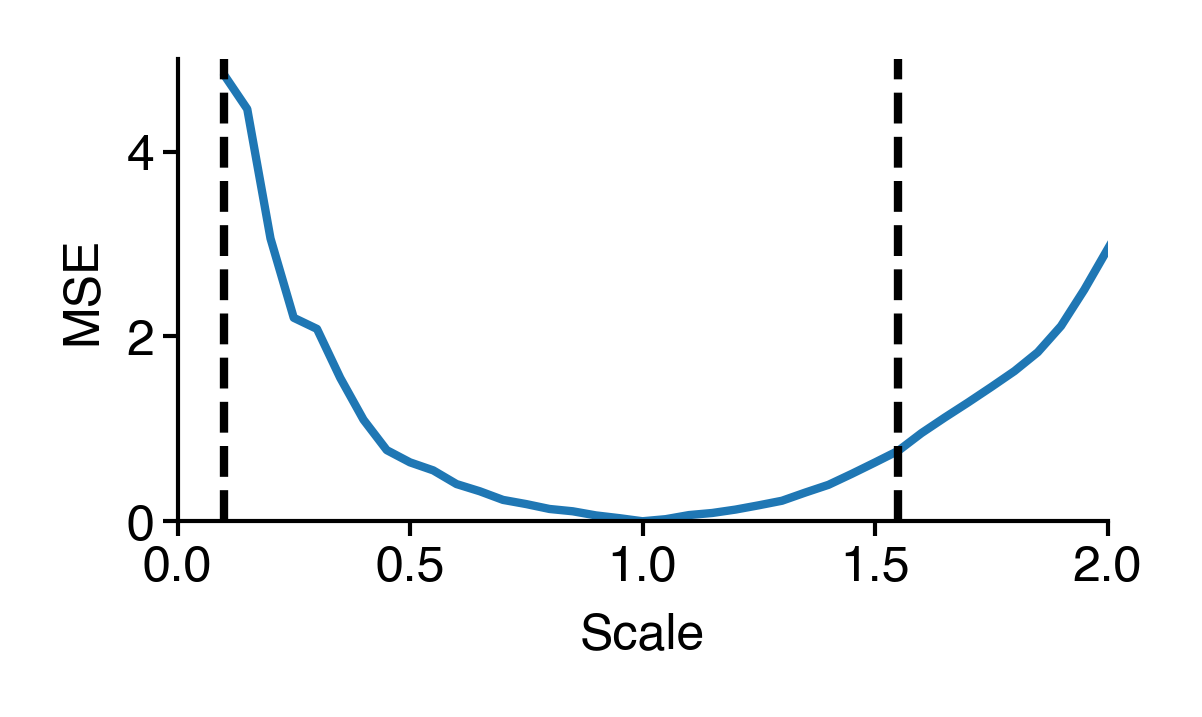

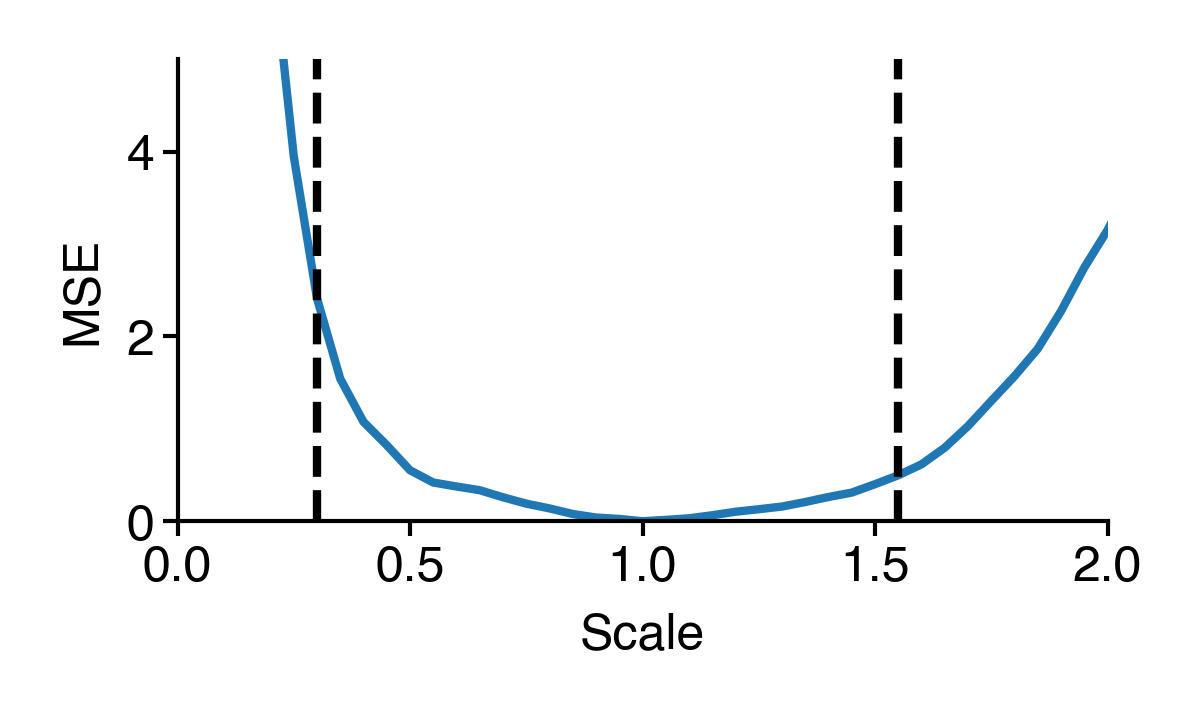

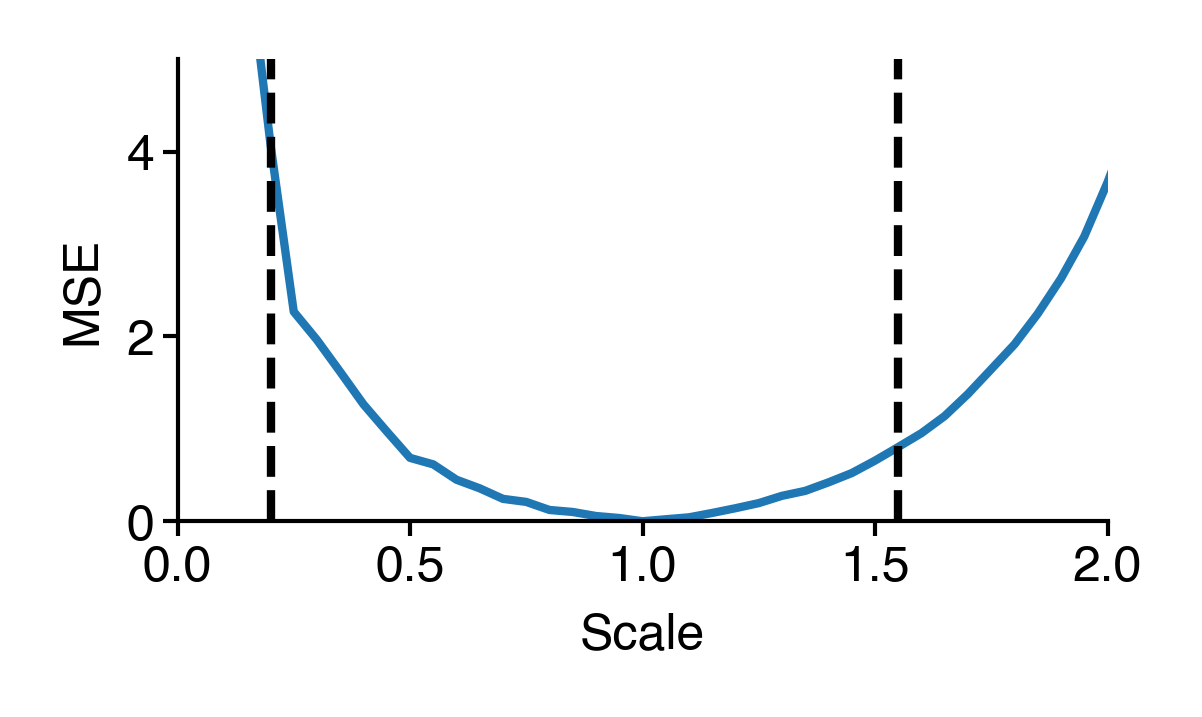

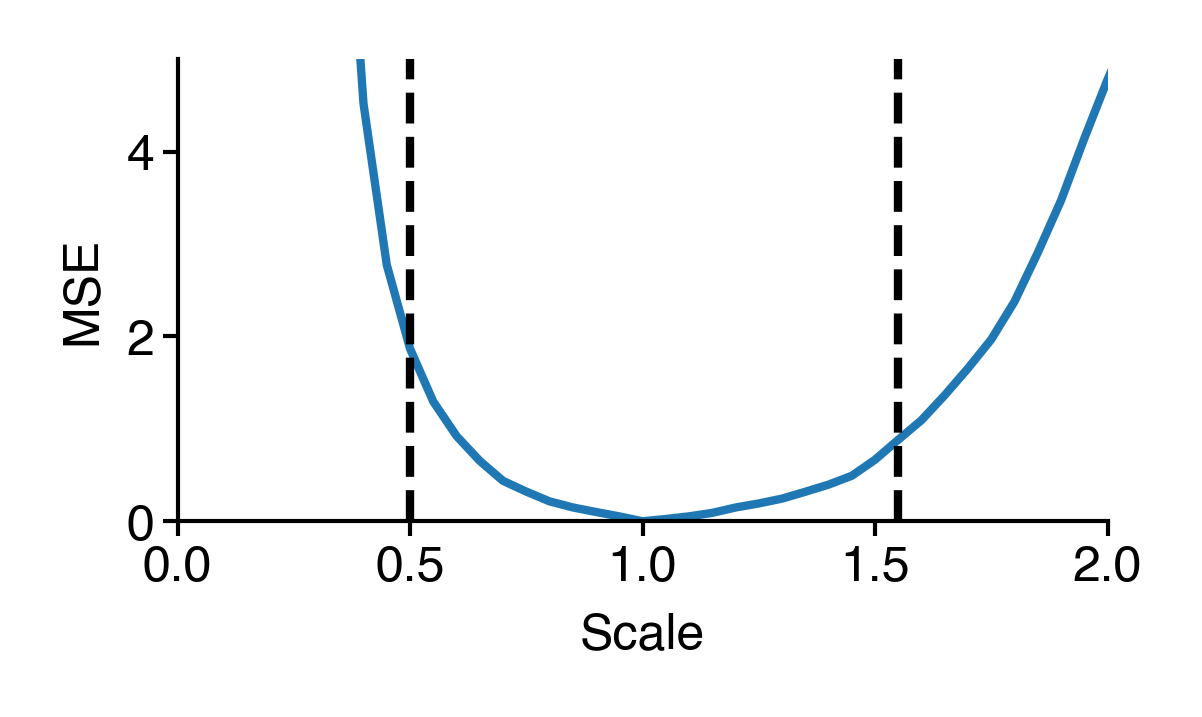

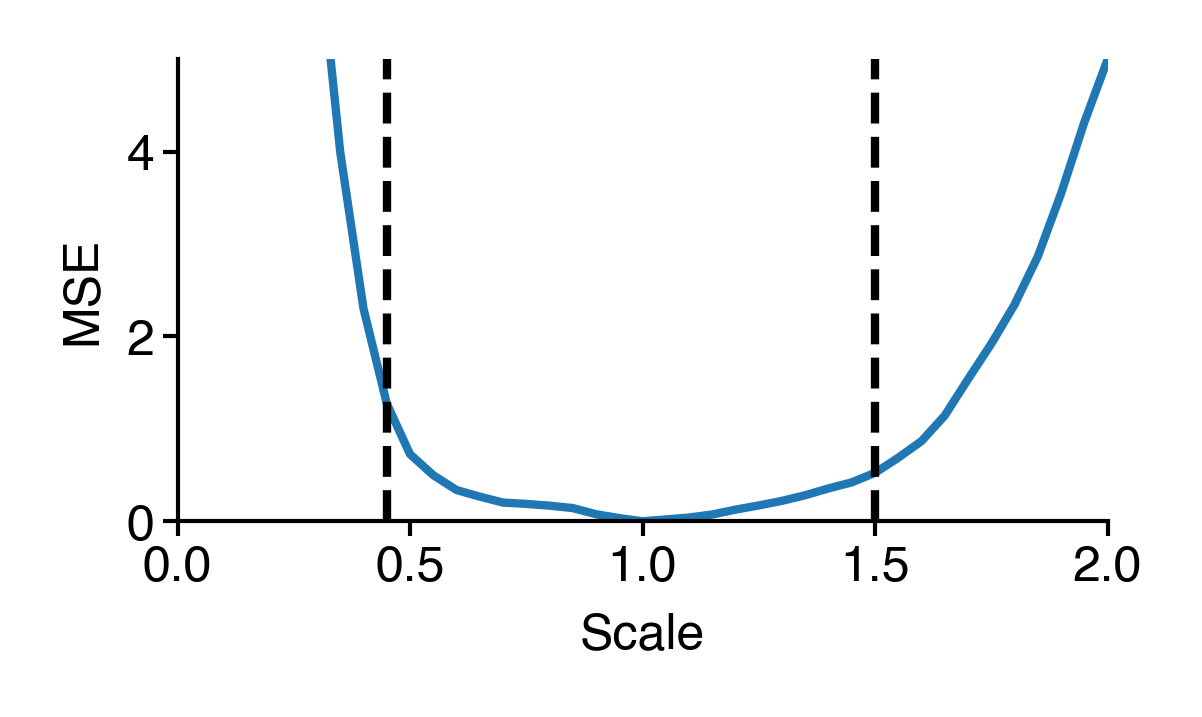

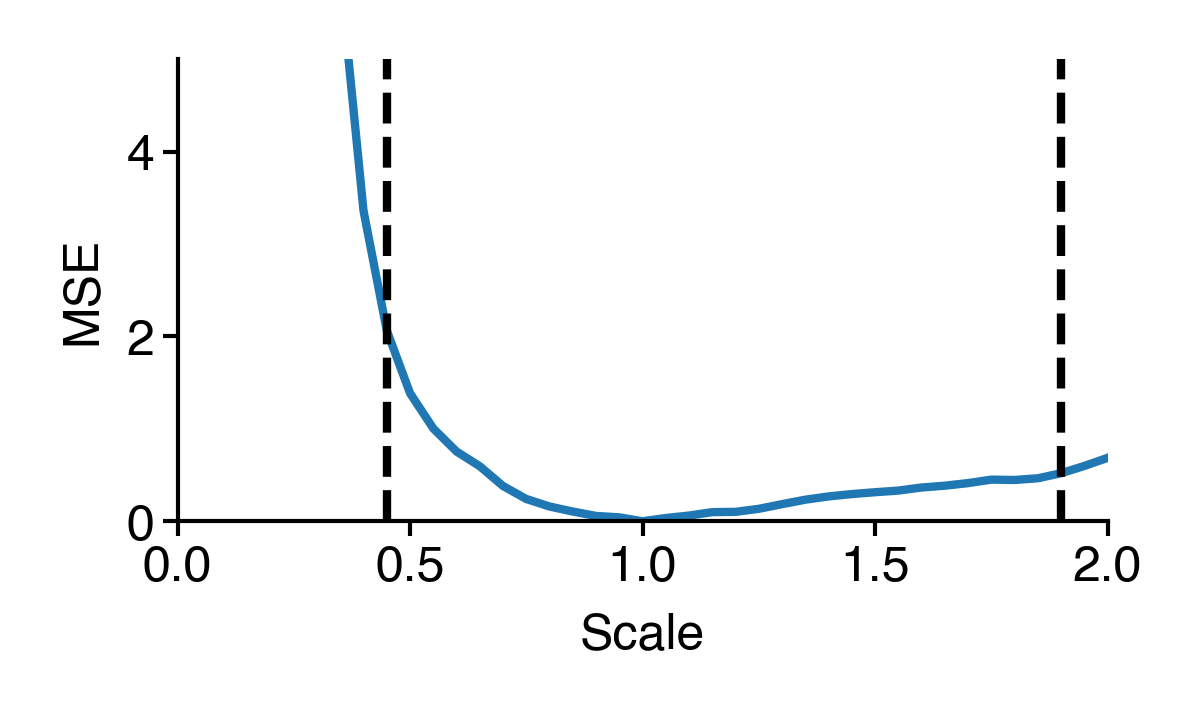

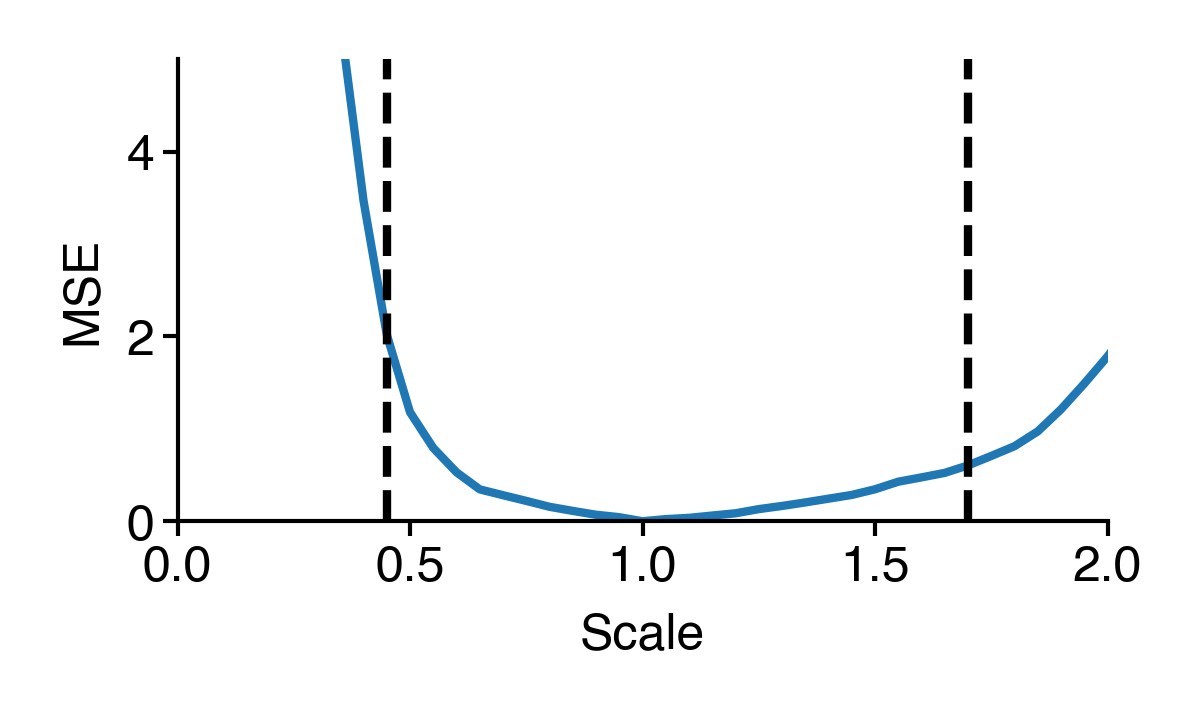

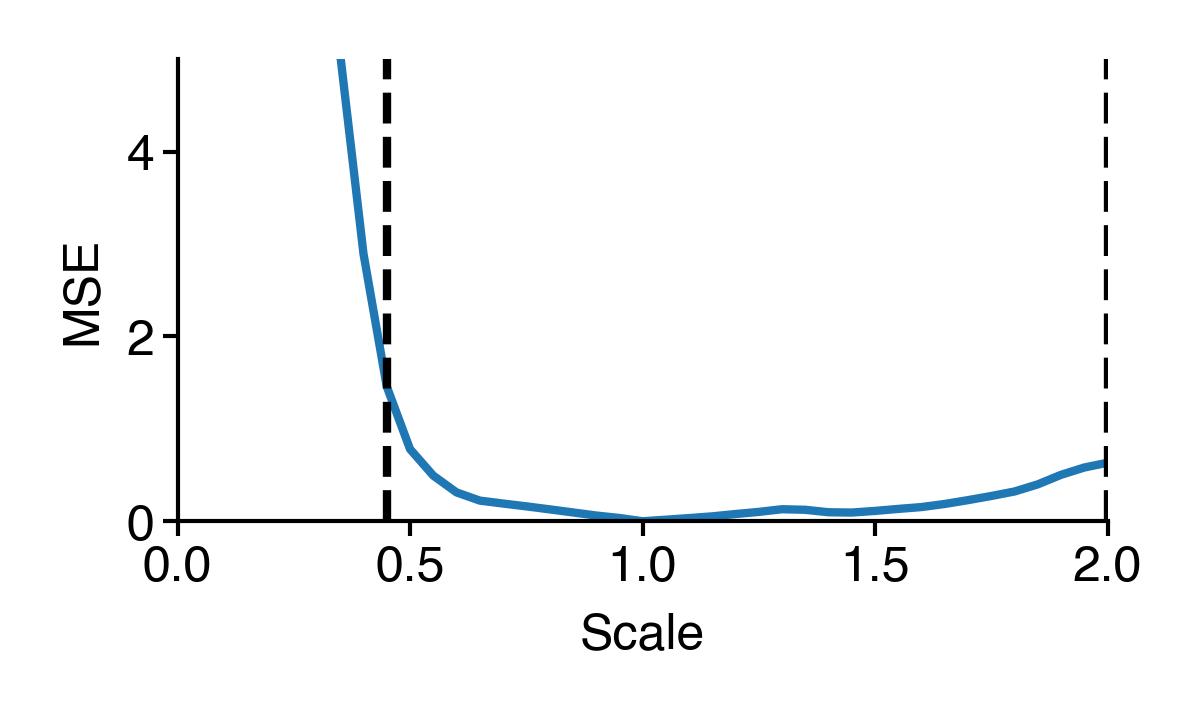

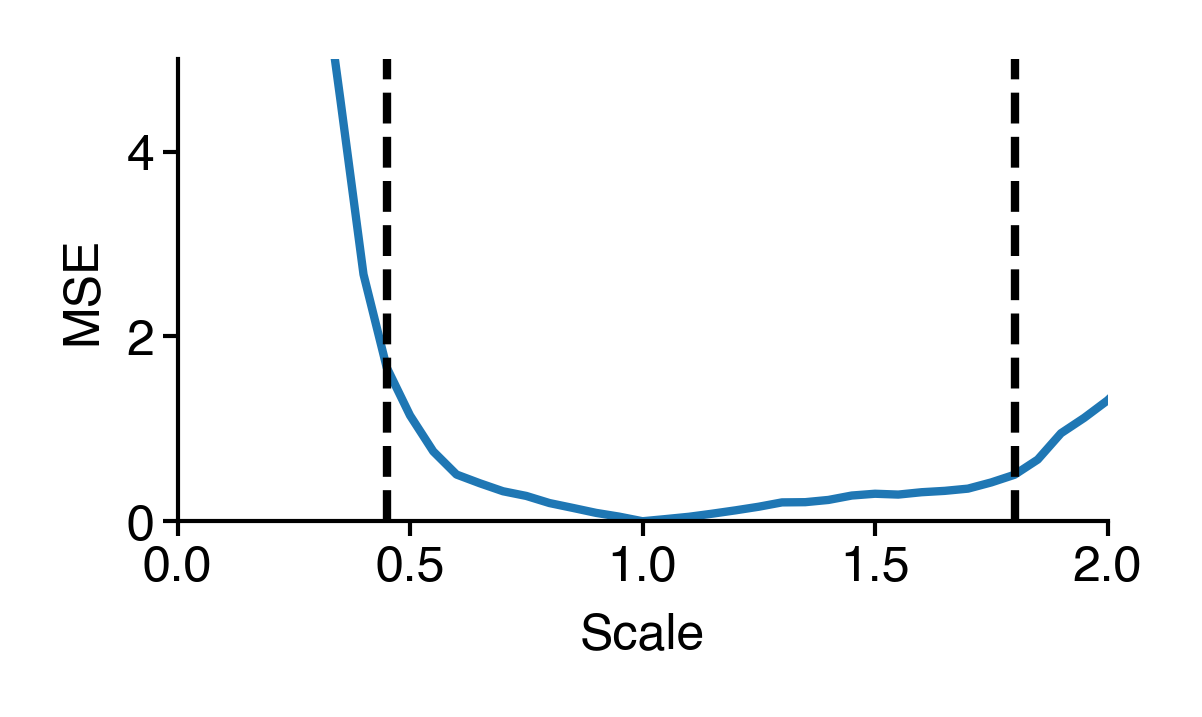

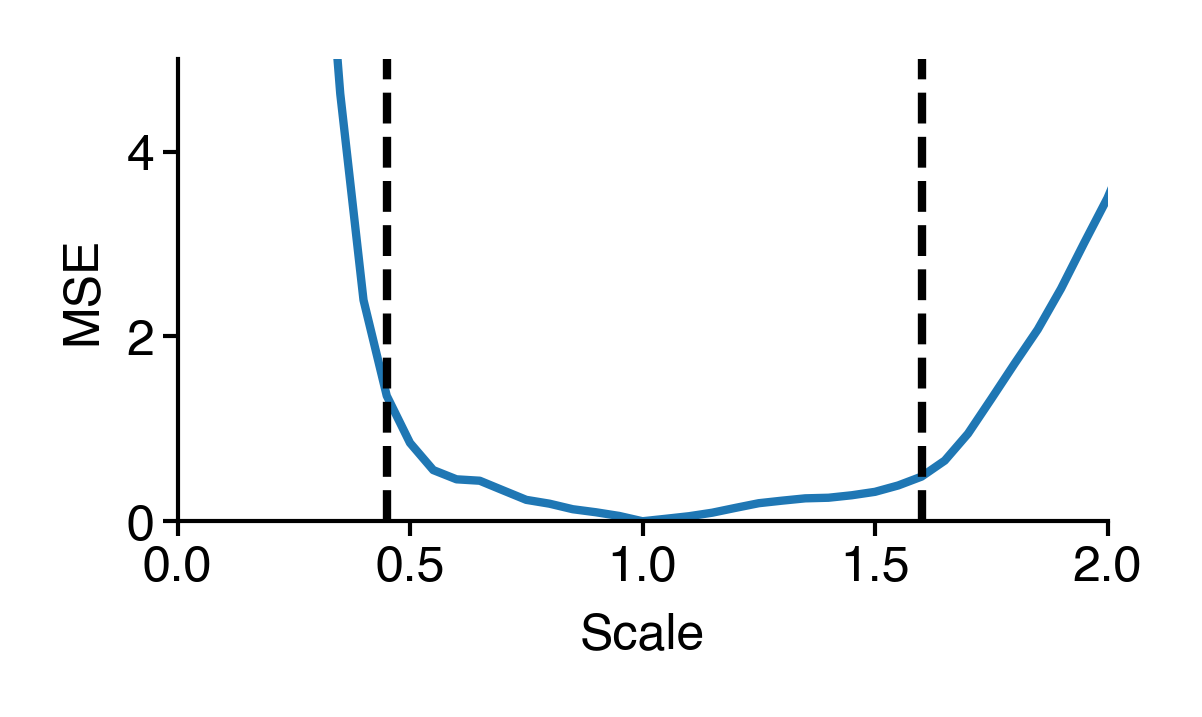

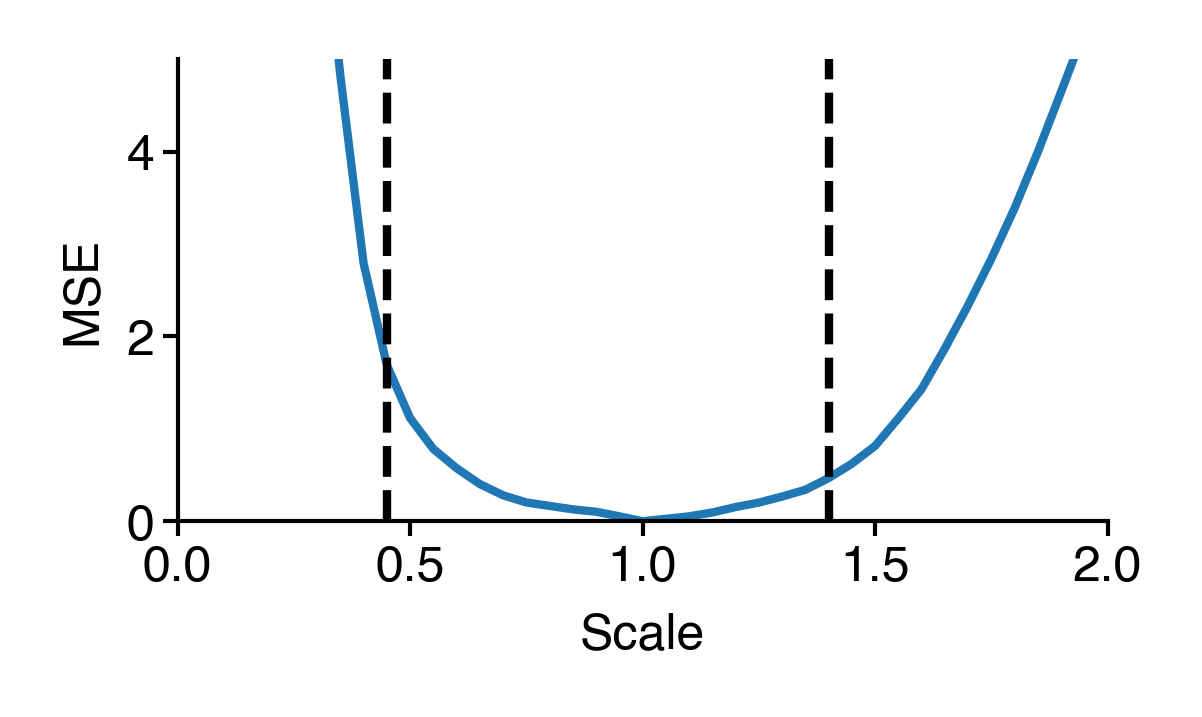

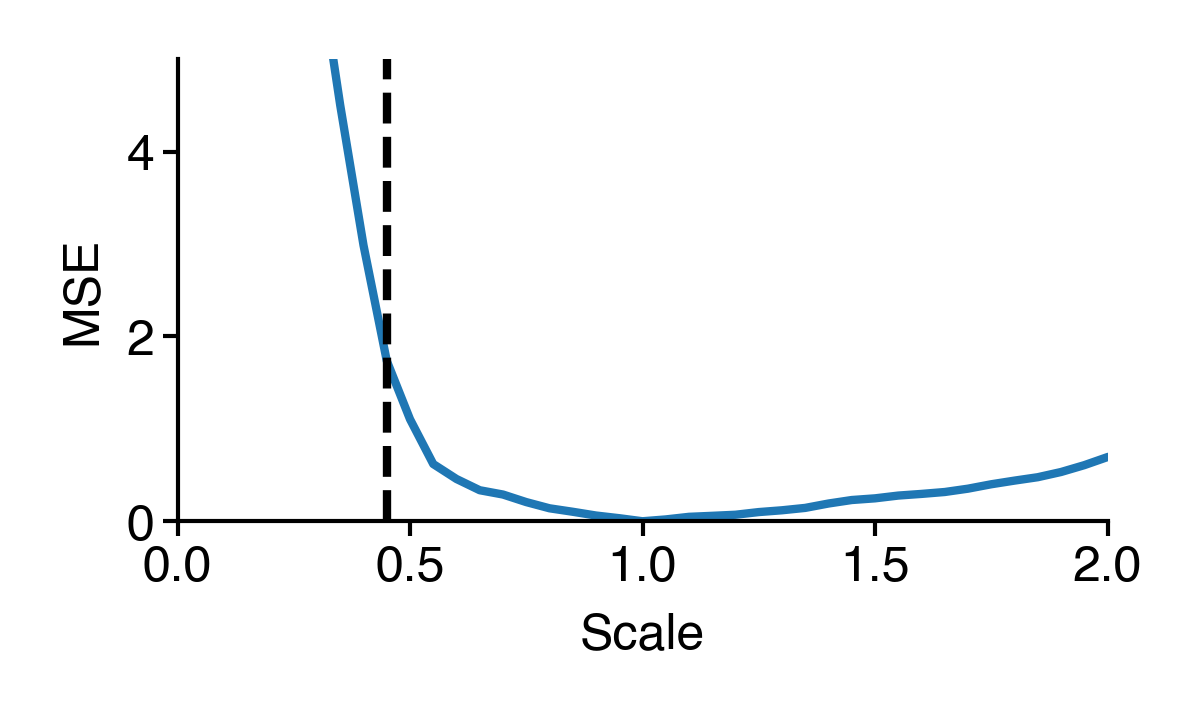

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
scales = np.linspace(0.1, 2.1, 41)

output = []
for model_path in tqdm(model_paths):
    config = toml.load(model_path.with_name("config.toml"))
    data = {
        "min_x_scale": config["augmentation"]["scale_x"][0],
        "max_x_scale": config["augmentation"]["scale_x"][1],
        "min_y_scale": config["augmentation"]["scale_y"][0],
        "max_y_scale": config["augmentation"]["scale_y"][1],
        "path": str(model_path),
    }
    mdl = torch.jit.load(model_path, map_location=device).eval()

    errors = []
    for frame in test_frames:
        batch = np.tile(frame, (len(scales), 1, 1, 1))
        comparison = predict(Session(frame[None]), mdl, batch_size=1, disable=True)
        resized = scale(
            torch.tensor(batch, dtype=torch.float32),
            torch.tensor(np.stack([scales, scales], axis=1), dtype=torch.float32),
        )
        resized_output = predict(
            Session(resized.squeeze().numpy()),
            mdl,
            batch_size=len(resized),
            disable=True,
        )
        squared_error = np.square(resized_output - comparison)
        squared_error = np.mean(squared_error, axis=(1, 2))
        errors.append(squared_error)
    errors = np.mean(errors, axis=0)
    data["errors"] = errors
    data["scales"] = scales

    output.append(data)

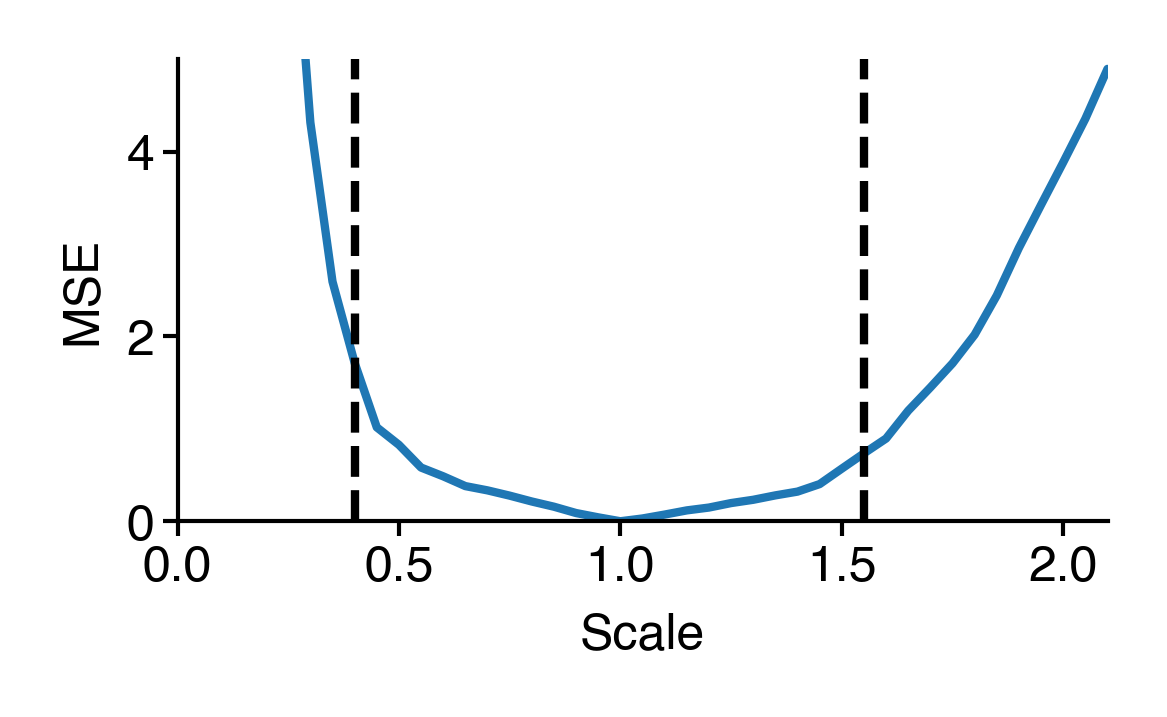

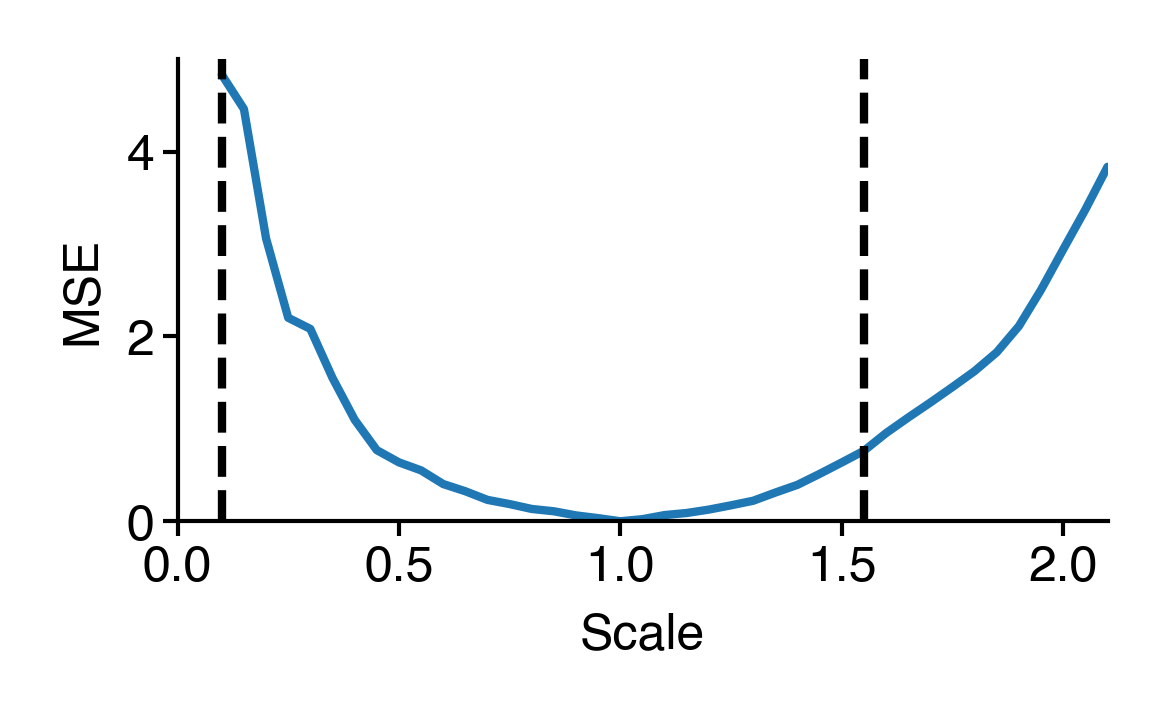

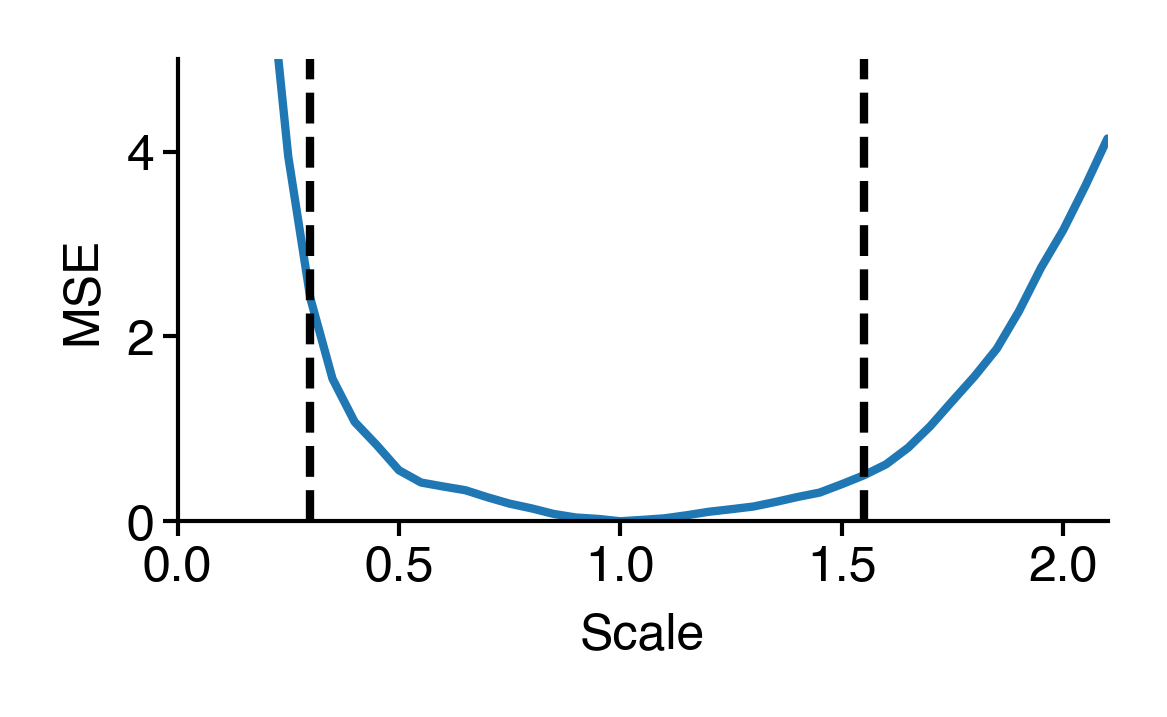

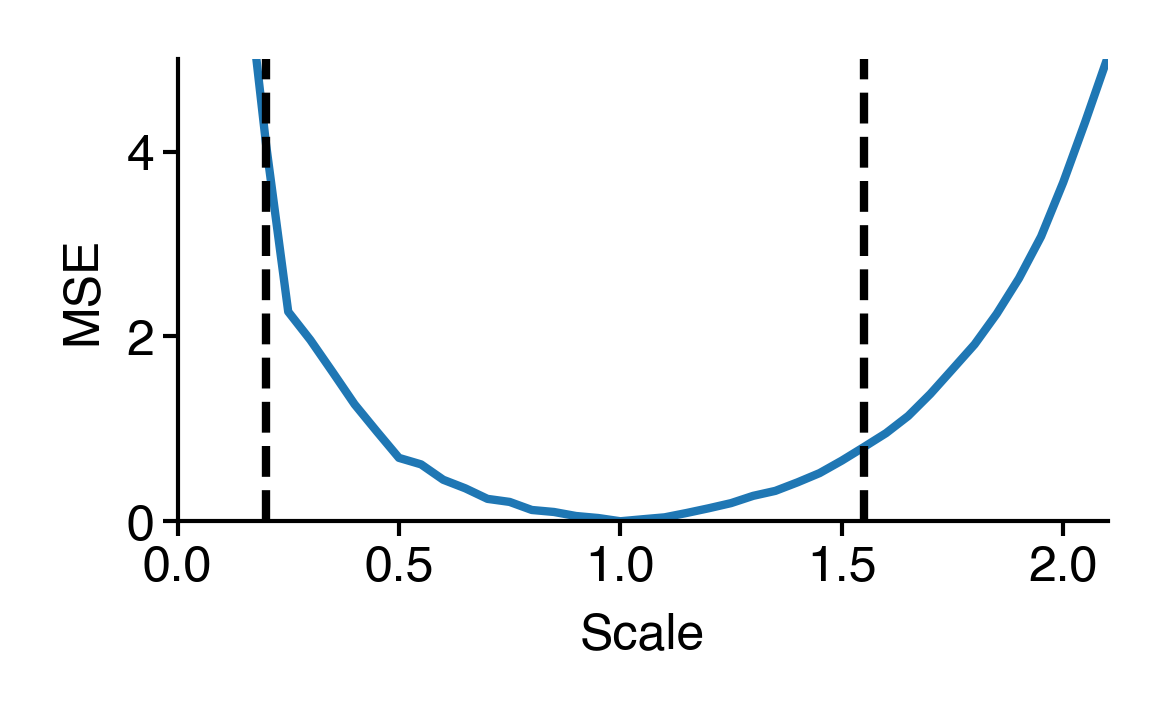

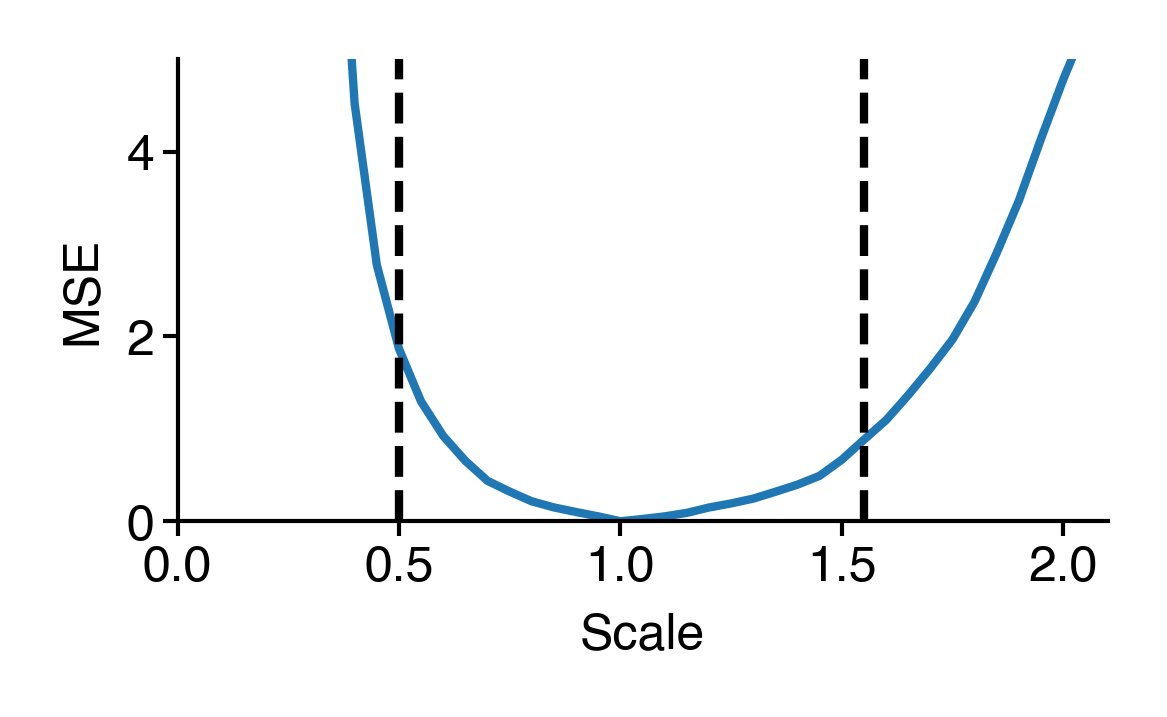

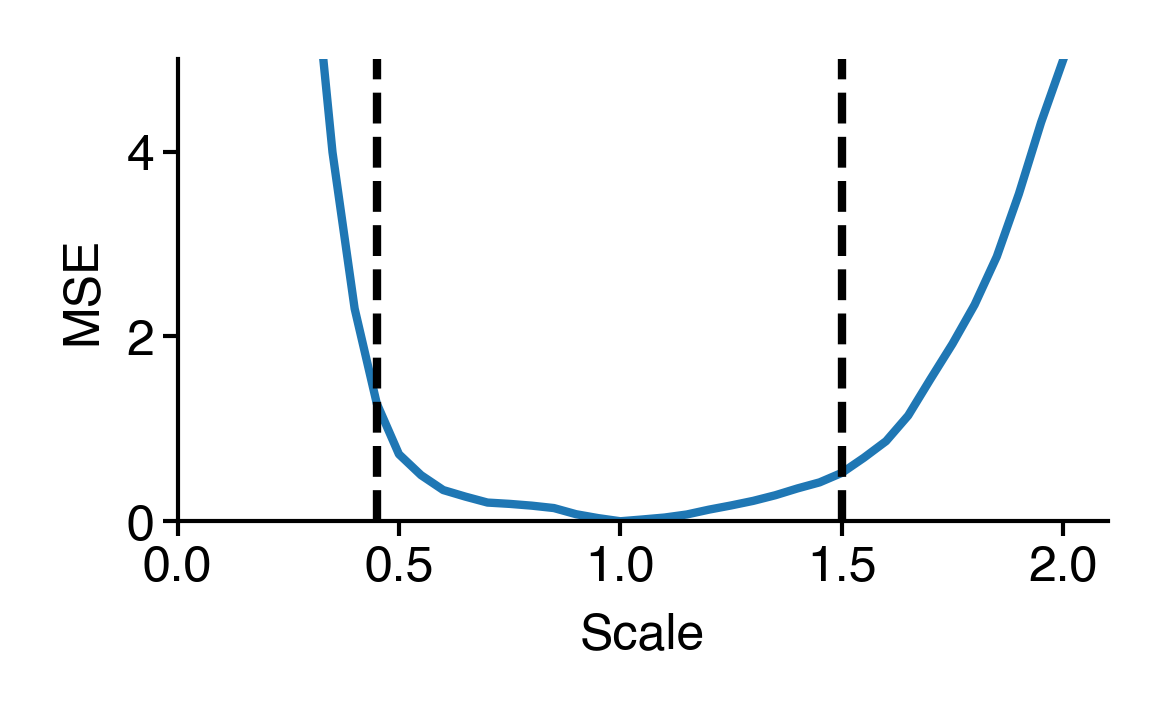

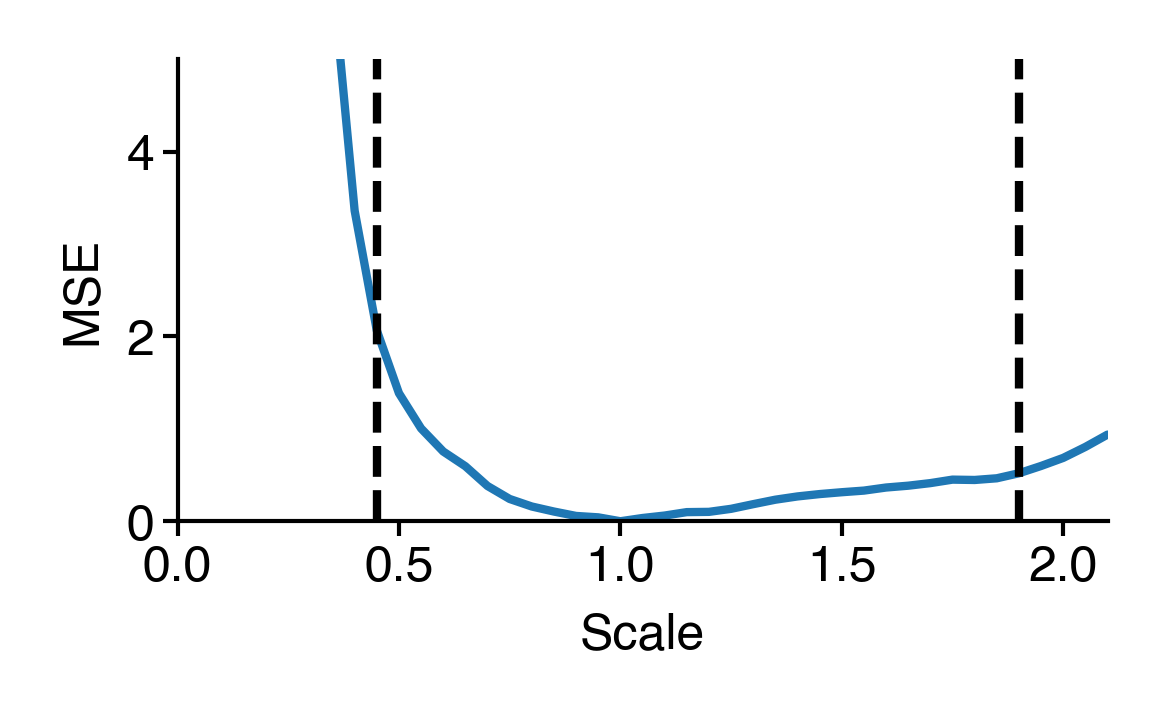

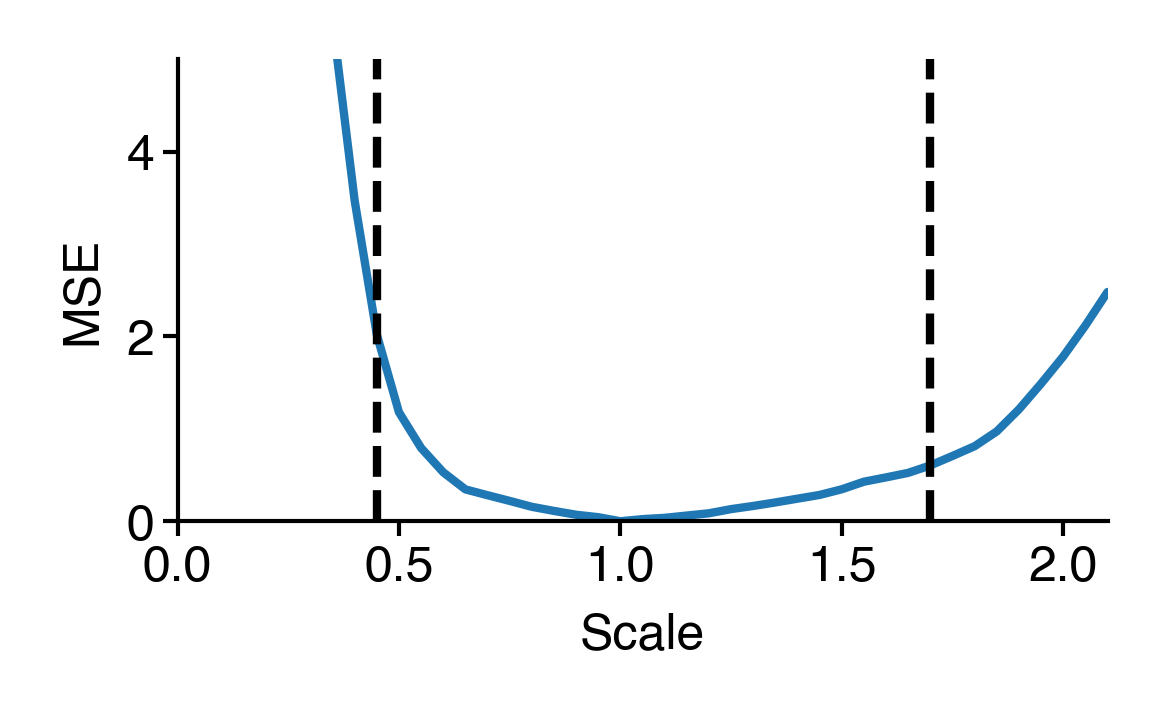

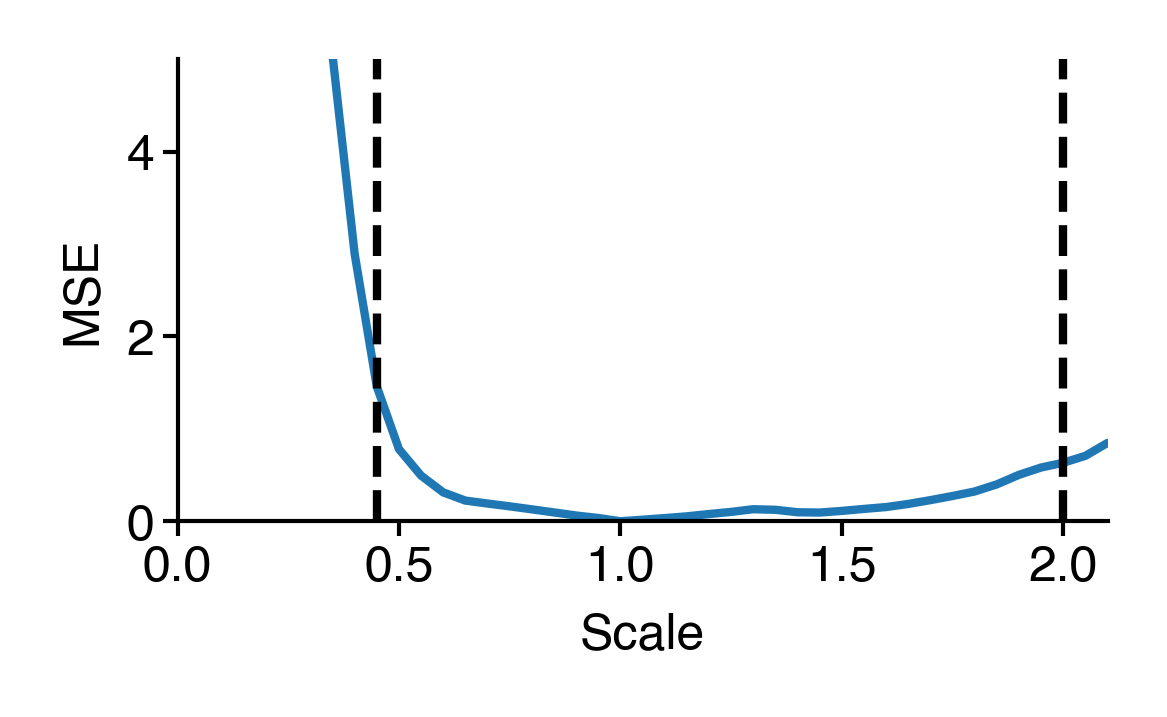

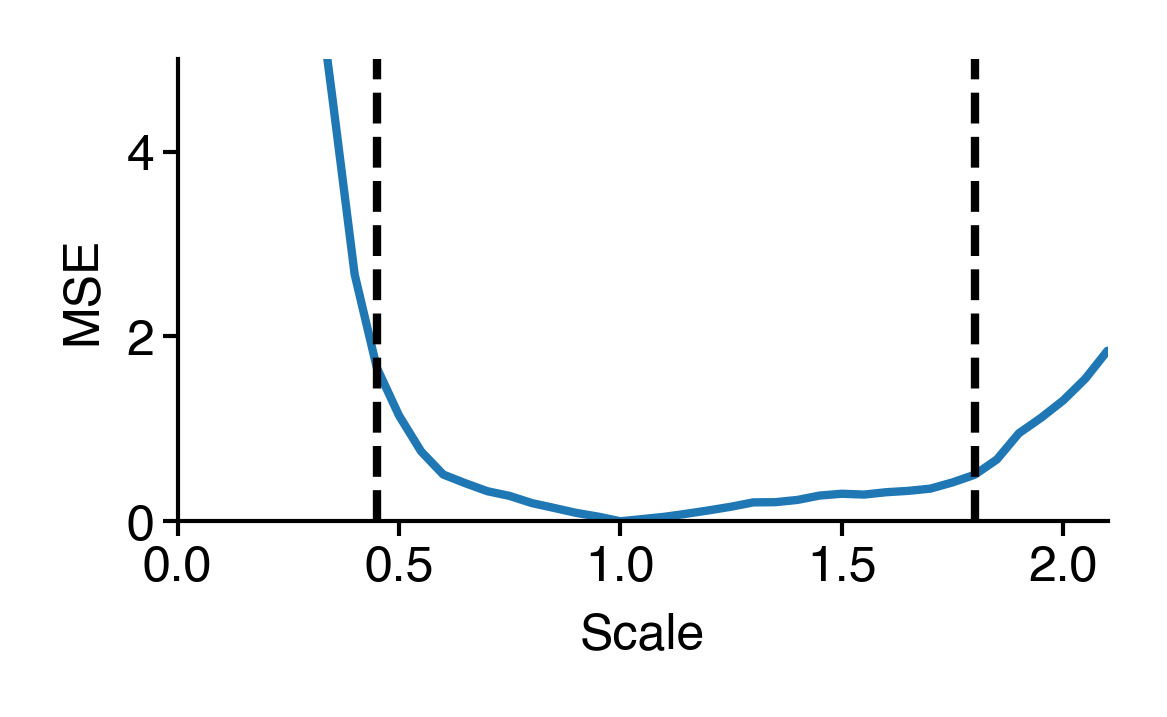

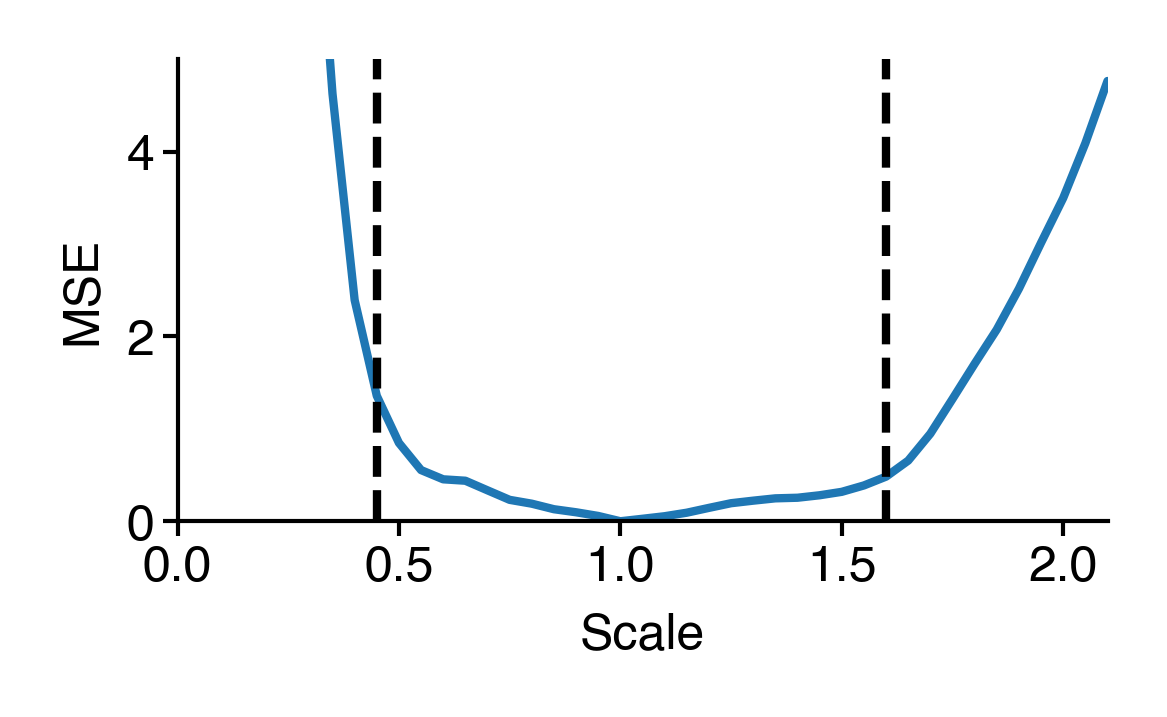

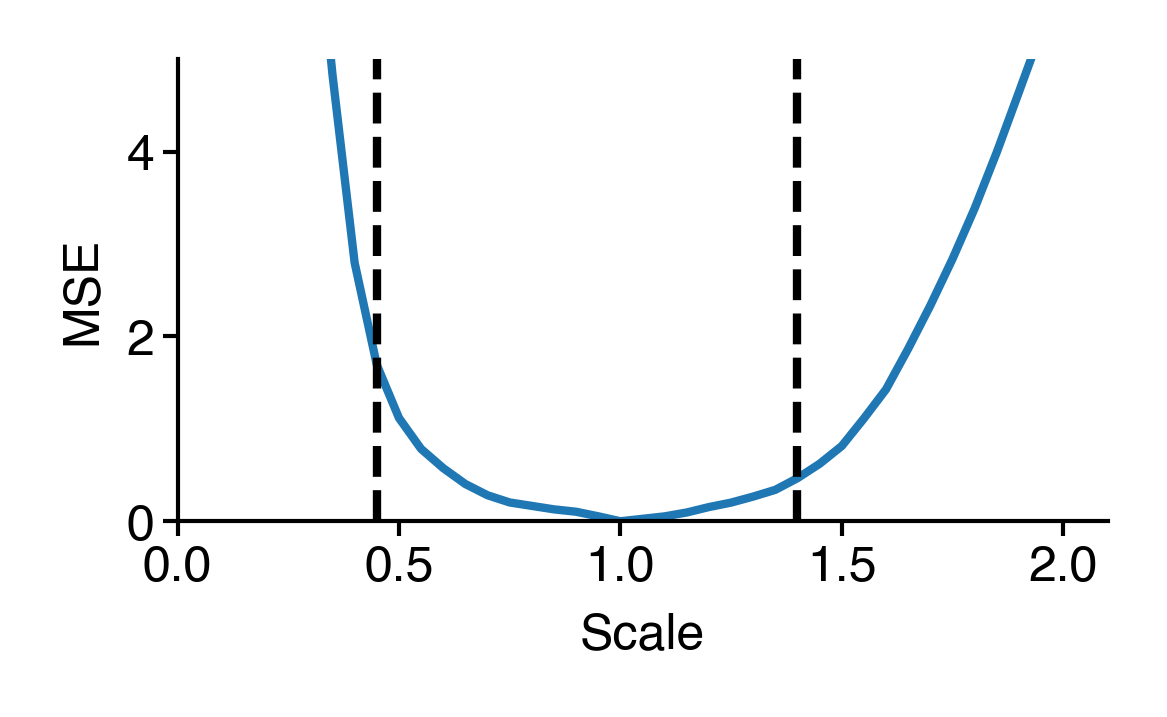

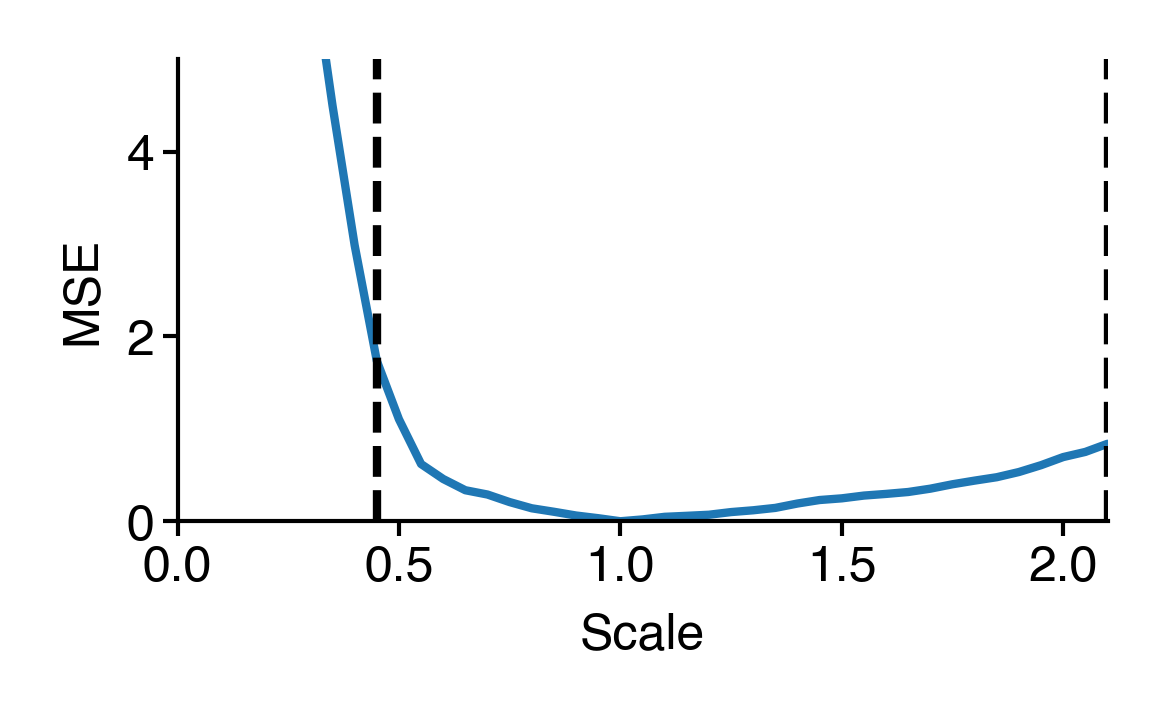

In [11]:
for data in output:
    figure(2, 1)
    plt.plot(data["scales"], data["errors"])
    plt.axvline(data["min_x_scale"], color="k", linestyle="--")
    plt.axvline(data["max_x_scale"], color="k", linestyle="--")
    plt.xlim(0, 2.1)
    plt.ylim(0, 5)
    plt.xlabel('Scale')
    plt.ylabel('MSE')
    sns.despine()

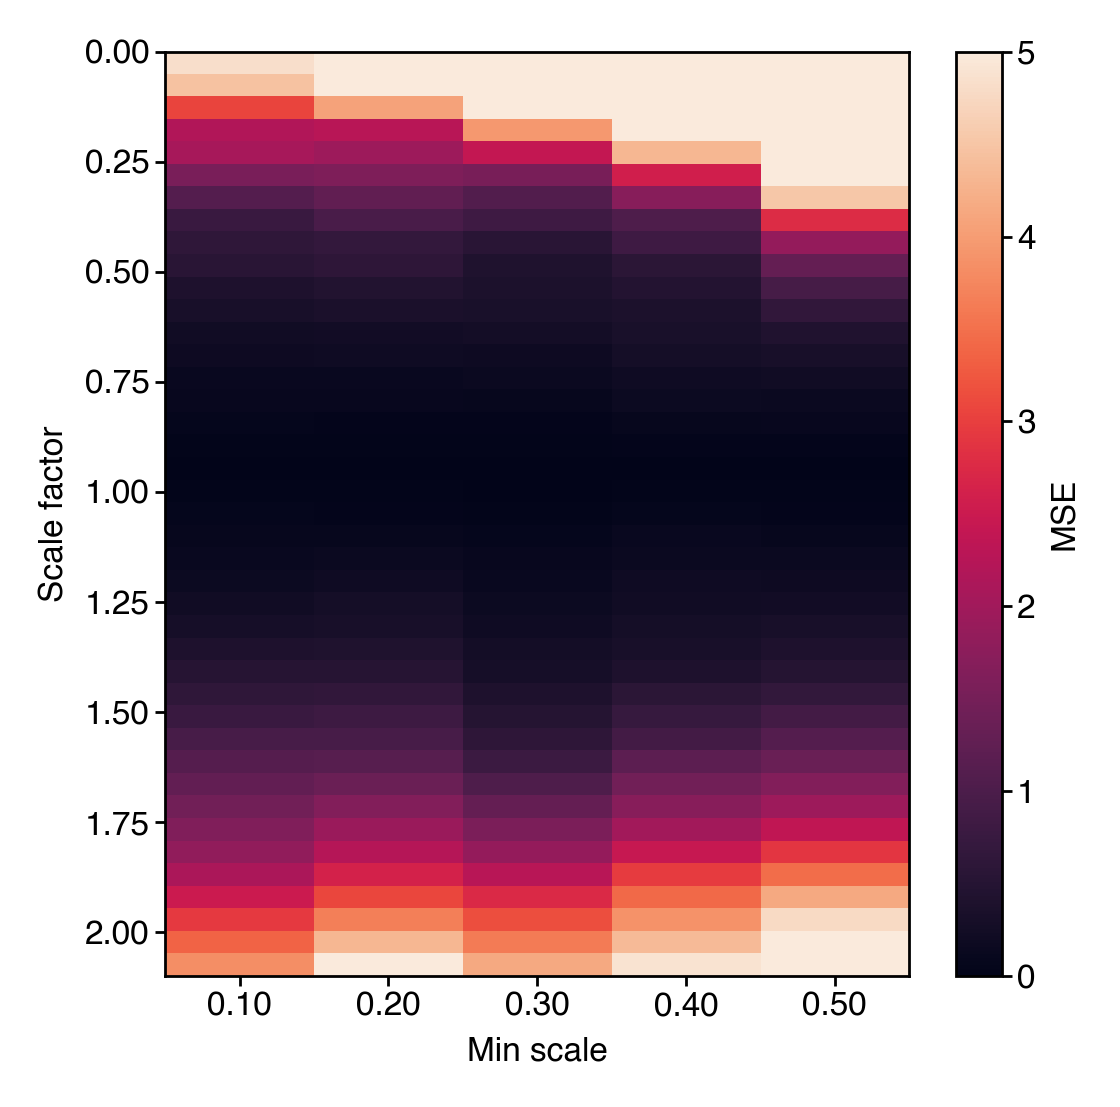

In [44]:
filtered = [data for data in output if data["max_x_scale"] == 1.55]
filtered = sorted(filtered, key=lambda x: x["min_x_scale"])
plt.imshow(np.array([data["errors"] for data in filtered]).T, aspect="auto", extent=(-0.5, len(filtered) - 0.5, 2.1, 0), vmax=5)
plt.xticks(range(len(filtered)), [f"{data['min_x_scale']:.2f}" for data in filtered])
plt.xlabel("Min scale")
plt.ylabel("Scale factor")
plt.colorbar(label="MSE")

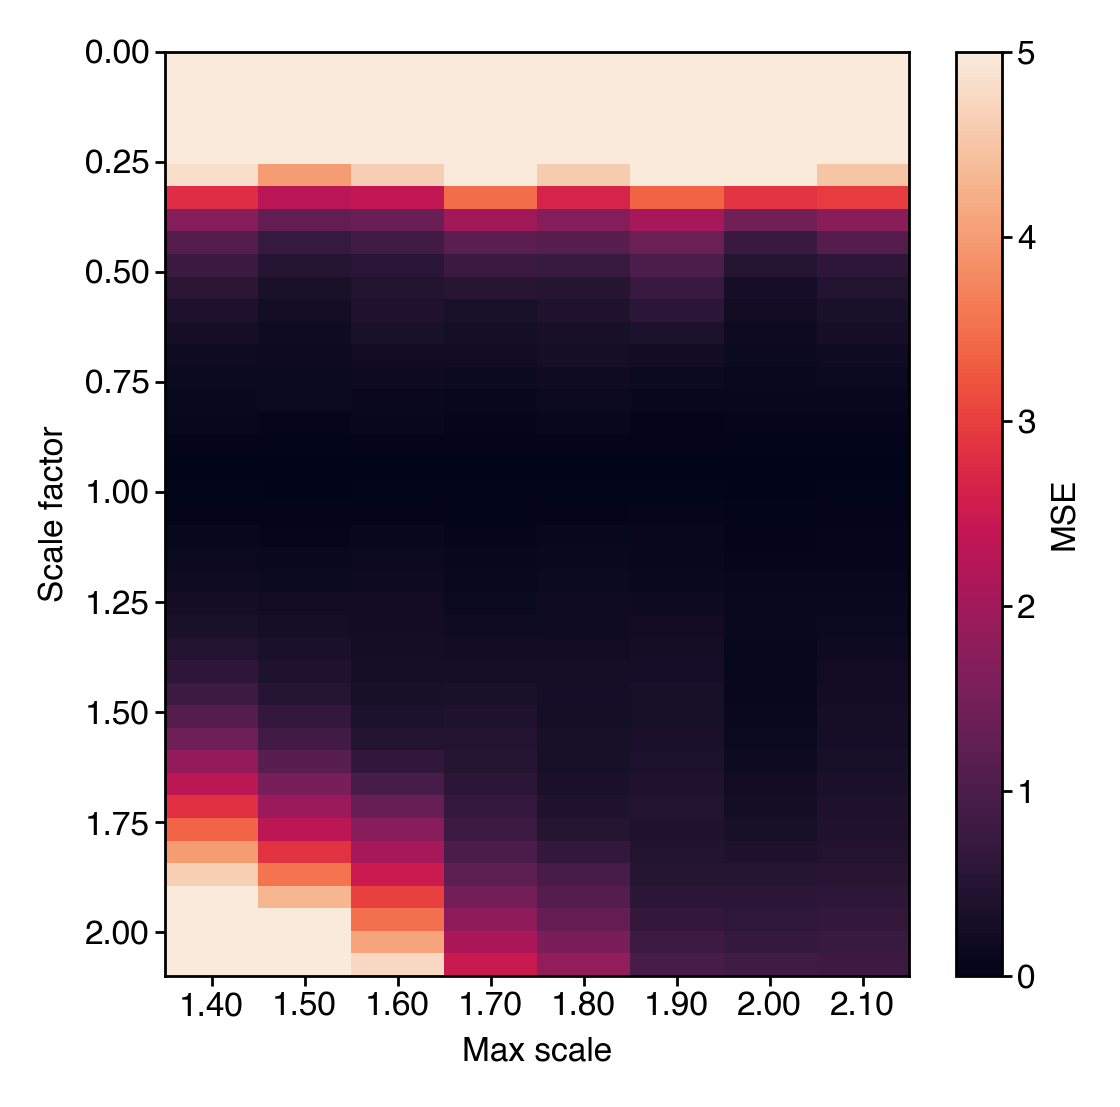

In [45]:
filtered = [data for data in output if data["min_x_scale"] == 0.45]
filtered = sorted(filtered, key=lambda x: x["max_x_scale"])
plt.imshow(np.array([data["errors"] for data in filtered]).T, aspect="auto", extent=(-0.5, len(filtered) - 0.5, 2.1, 0), vmax=5)
plt.xticks(range(len(filtered)), [f"{data['max_x_scale']:.2f}" for data in filtered])
plt.xlabel("Max scale")
plt.ylabel("Scale factor")
plt.colorbar(label="MSE")